In [60]:
# 필요한 라이브러리 구축 - local로 하다보니 하나하나 설치해줘야하는게 귀찮다....

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

!pip install missingno
import missingno as msno

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

!pip install xgboost
!pip install lightgbm
!pip install catboost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# path 설정 
ROOT_DIR = "~/aiffel/kaggle_kakr_housing/data" # 필요시 변경

train_data_path = join(ROOT_DIR, 'train.csv')
sub_data_path = join(ROOT_DIR, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [62]:
# dataset 읽어오기 - shape 사용하여 개수 파악
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [63]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [64]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [65]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

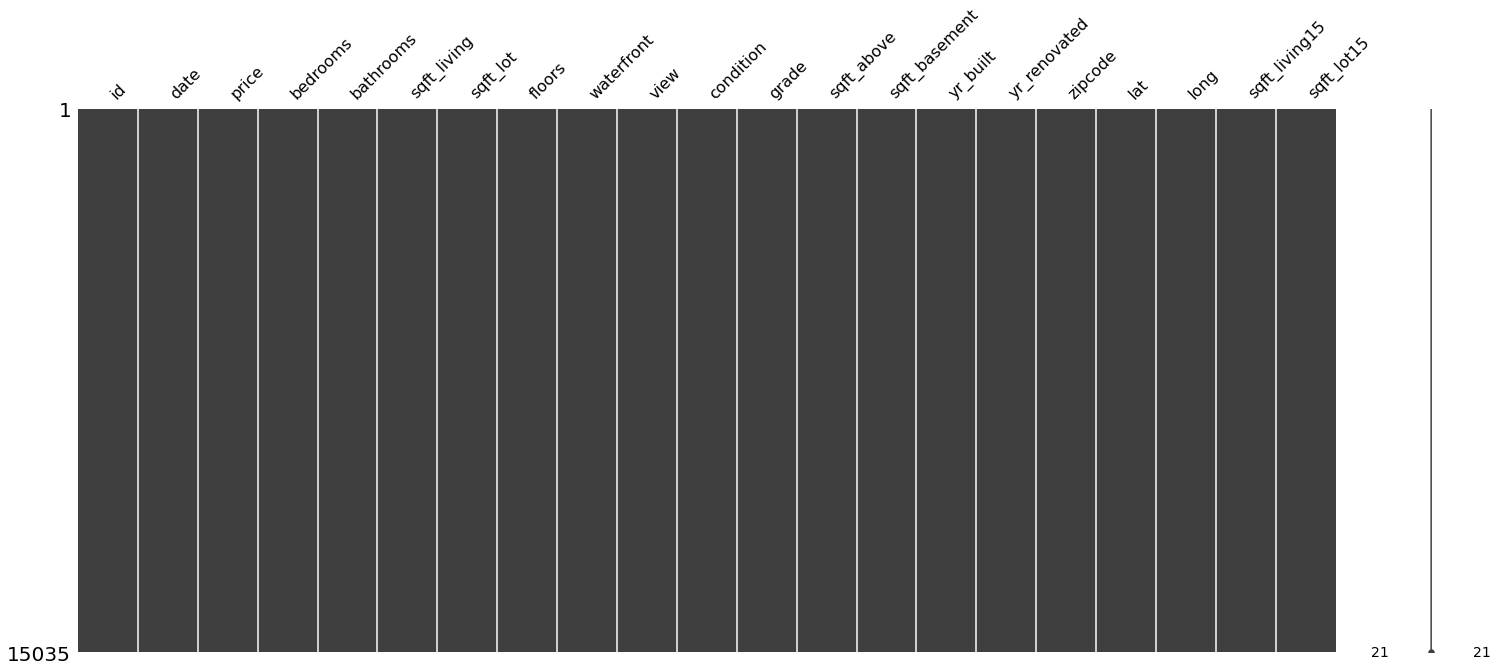

In [66]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [67]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [68]:
# 기존 데이터를 잃지 않기 위해 data copy - 이제 각종 실험을 진행할 예정
df = data.copy()
# id는 학습에 필요가 없으니 삭제 - 절대 필요할 일이 없다.

df = df.drop(columns=["id"])

# date 컬럼도 연/월/일로 나누고 date 컬럼 삭제
df['year'] = df['date'].str[:4].astype(int)
df['month'] = df['date'].str[4:6].astype(int)
df['day'] = df['date'].str[6:8].astype(int)

df = df.drop(columns=["date"])

In [69]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
count,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,...,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,...,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935,2014.319654,6.580579,15.695045
std,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,...,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787,0.466358,3.106349,8.649851
min,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,...,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000,2014.000000,6.000000,16.000000
75%,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000,2015.000000,9.000000,23.000000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

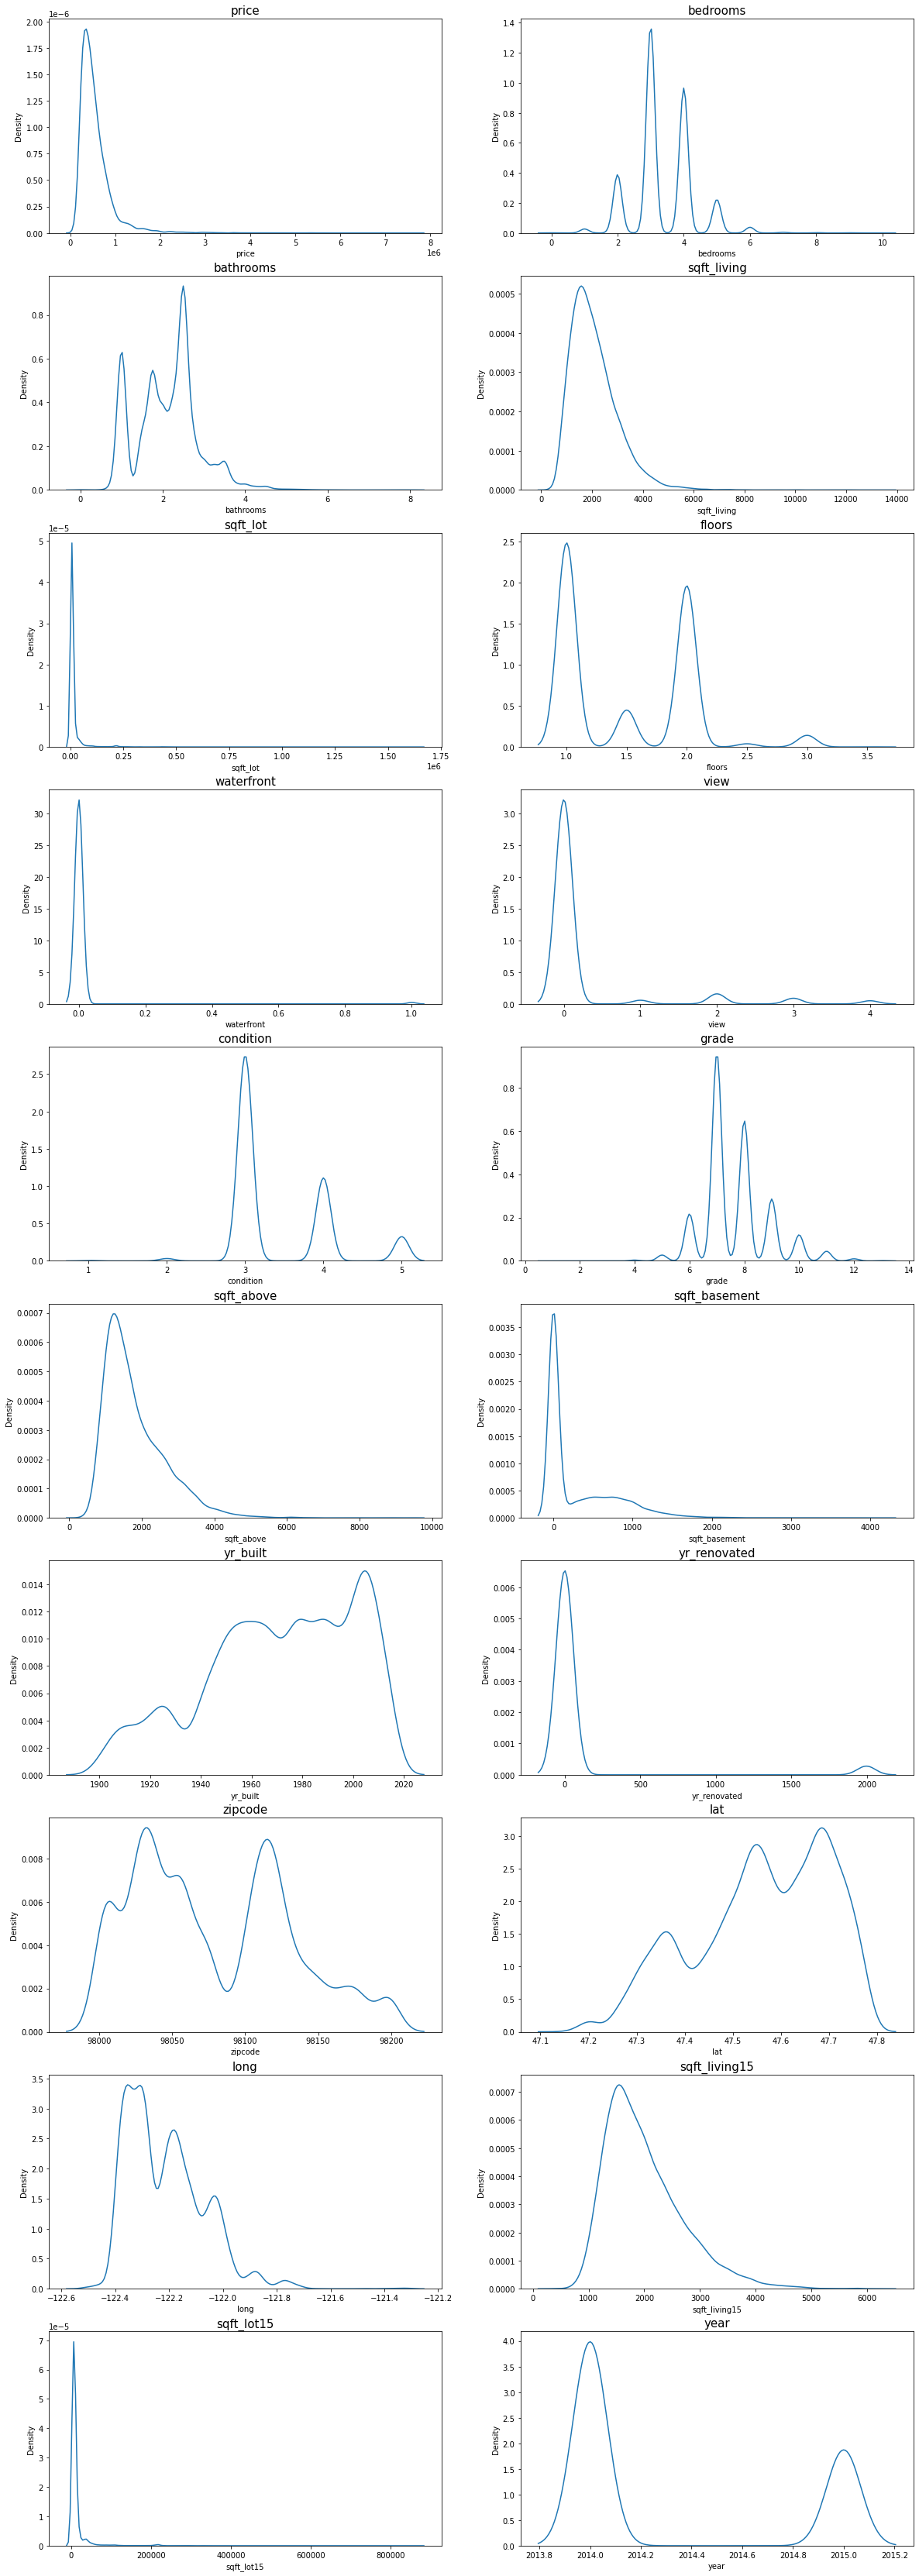

In [70]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = df.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 22 :
            break

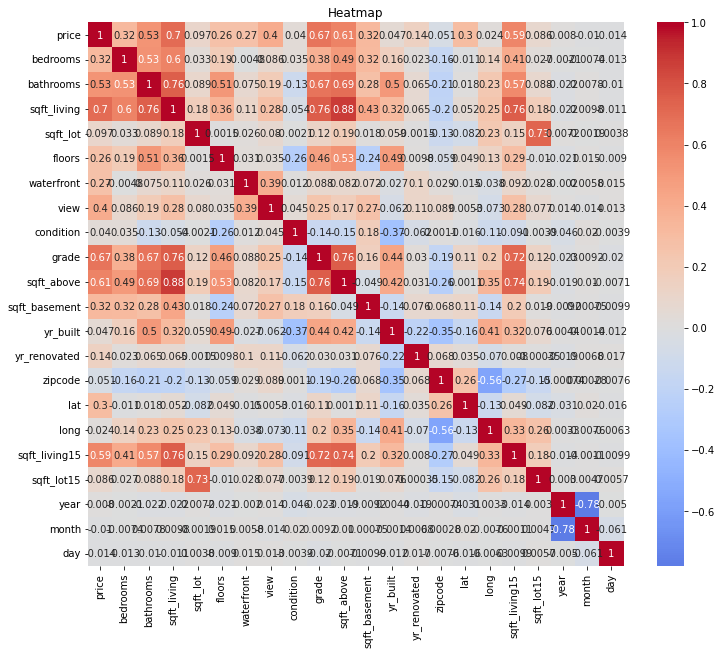

In [71]:
corr = df.corr()

# 히트맵을 통한 상관관계 확인
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap')
plt.show()

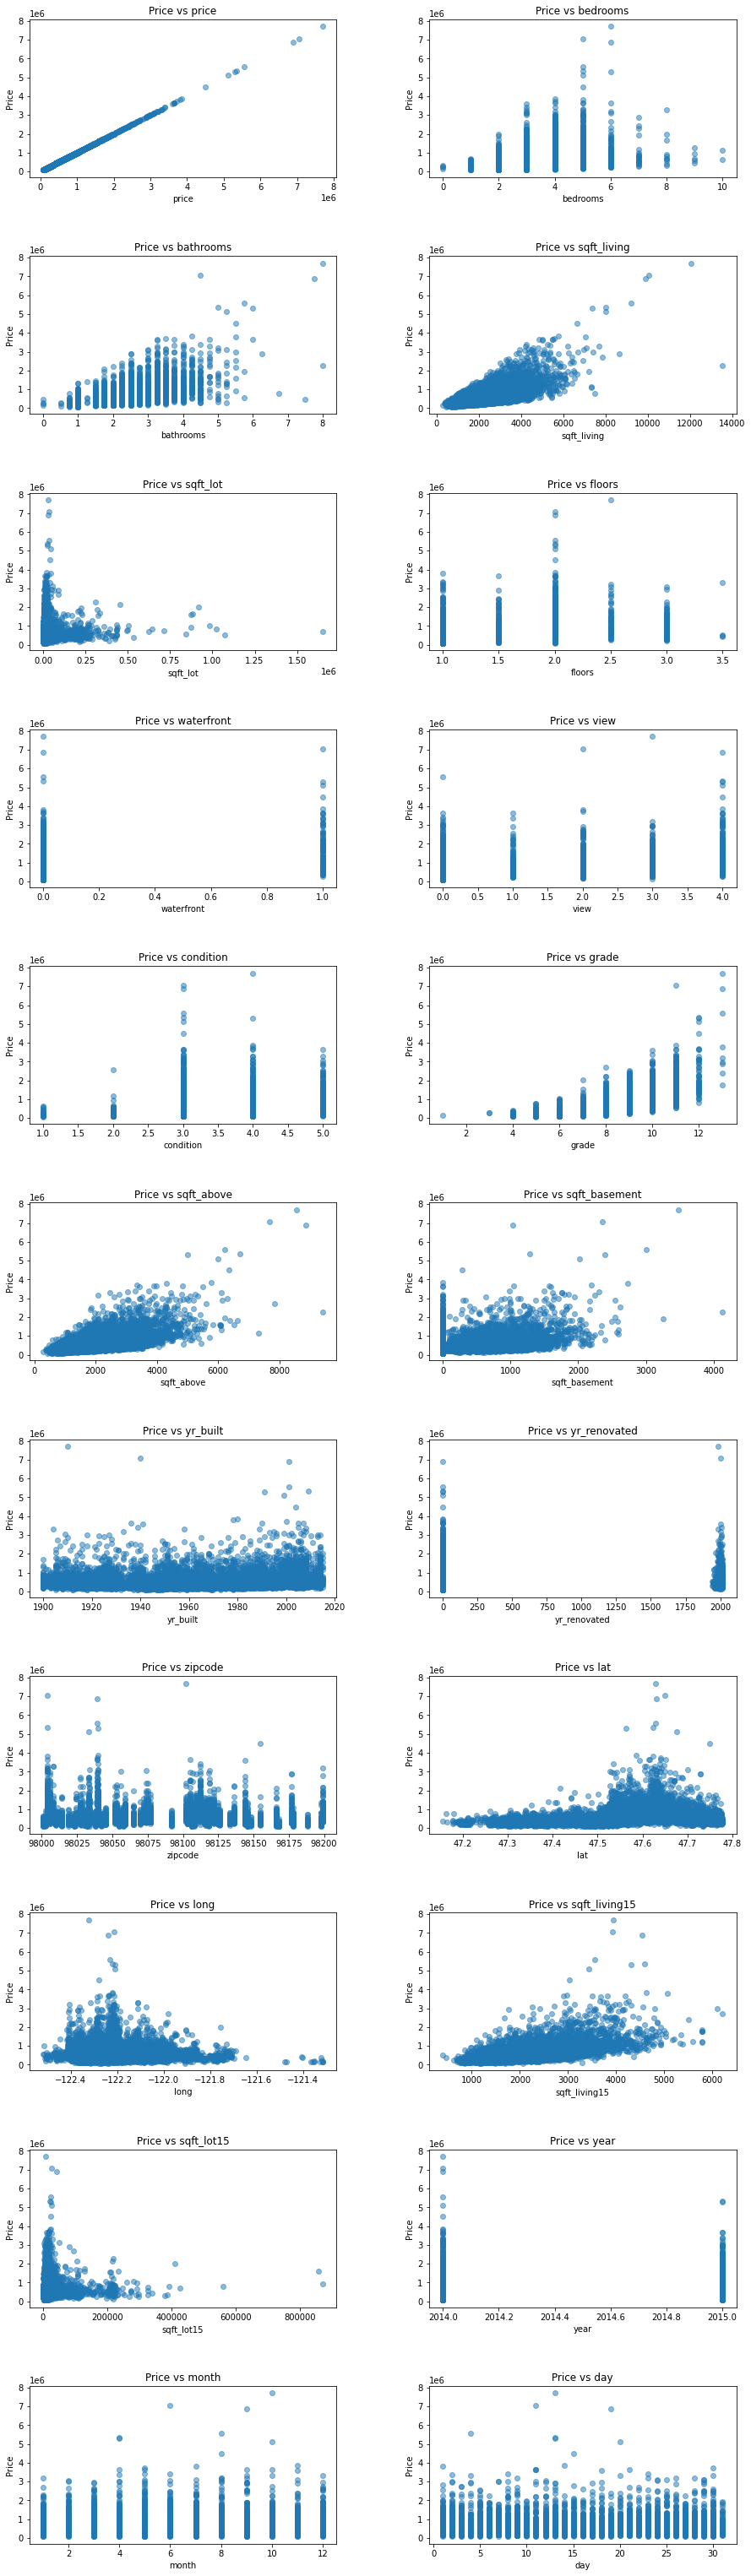

In [72]:
# 그래프에 사용할 변수 리스트
variables = df.columns

# 전체 변수 수
n_vars = len(variables)

# 그래프 크기 및 레이아웃 설정
fig, axes = plt.subplots(nrows=(n_vars + 1) // 2, ncols=2, figsize=(15, 5 * ((n_vars + 1) // 2)))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# 반복문을 통해 산점도 그리기
for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(df[var], df['price'], alpha=0.5)
    axes[row, col].set_title(f'Price vs {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Price')


plt.show()

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [73]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df[c] = np.log1p(data[c].values)

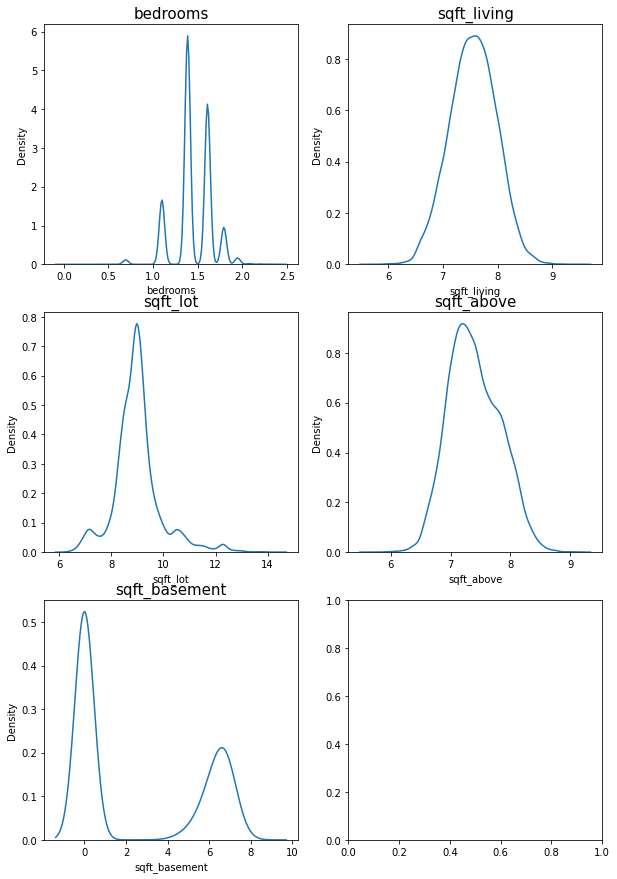

In [74]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(df[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

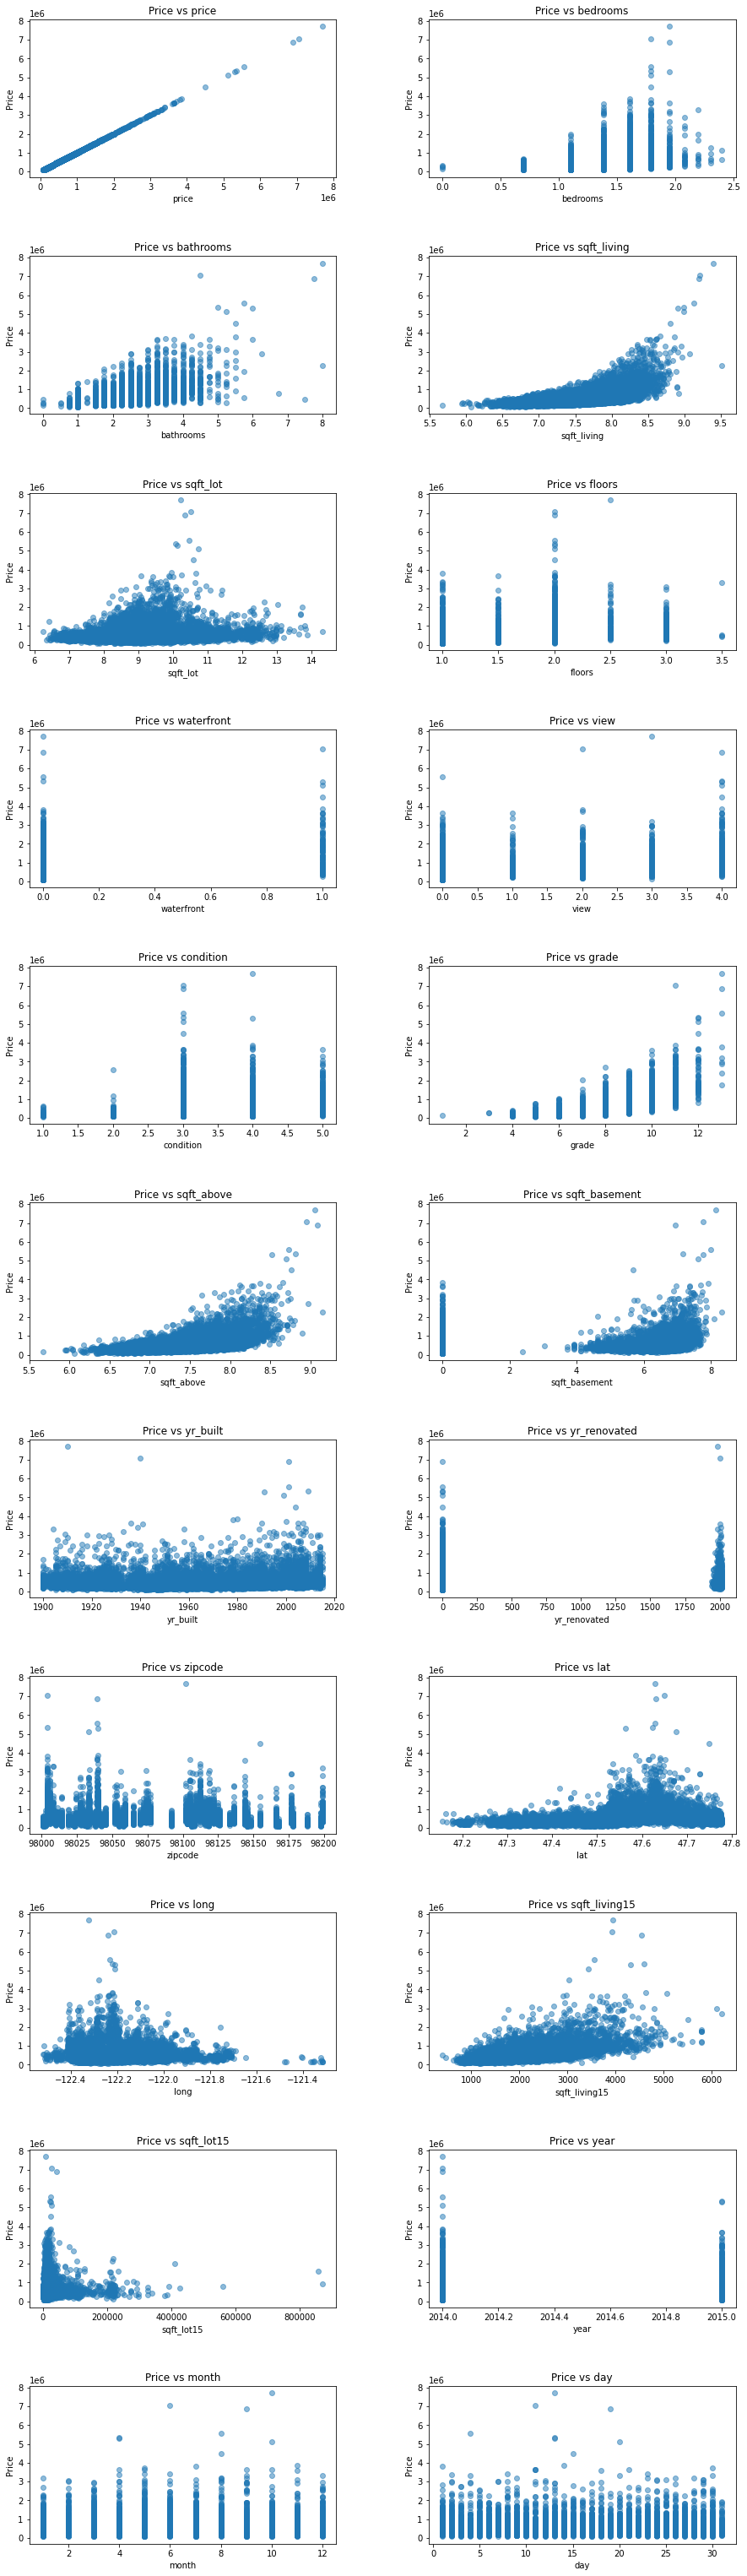

In [75]:
# 그래프에 사용할 변수 리스트
variables = df.columns

# 전체 변수 수
n_vars = len(variables)

# 그래프 크기 및 레이아웃 설정
fig, axes = plt.subplots(nrows=(n_vars + 1) // 2, ncols=2, figsize=(15, 5 * ((n_vars + 1) // 2)))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# 반복문을 통해 산점도 그리기
for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(df[var], df['price'], alpha=0.5)
    axes[row, col].set_title(f'Price vs {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Price')


plt.show()

In [76]:

data['dataset'] = 'data'
sub['dataset'] = 'sub'
combined = pd.concat([data, sub], ignore_index=True)

# ID 컬럼 삭제
combined = combined.drop(columns=["id"])

# date 컬럼을 연/월/일로 나누고 원래의 date 컬럼 삭제
combined['year'] = combined['date'].str[:4].astype(int)
combined['month'] = combined['date'].str[4:6].astype(int)

combined = combined.drop(columns=["date"])

# 치우침 있는 컬럼에 대해 로그 스케일링 적용
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15','sqft_lot15']

for c in skew_columns:
    combined[c] = np.log1p(combined[c].values)

# 새로운 피처 생성
combined['change_living'] = combined['sqft_living'] - combined['sqft_living15']
combined['change_lot'] = combined['sqft_lot'] - combined['sqft_lot15']

# 사용하지 않는 컬럼 삭제
combined = combined.drop(columns=['sqft_living15', 'sqft_lot15'])

# 연도와 월 컬럼에 대해 원핫 인코딩 진행
encoder = OneHotEncoder(sparse=False)
encoded_vars = encoder.fit_transform(combined[['year']])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['year']))

combined = pd.concat([combined, encoded_df], axis=1)
combined = combined.drop(columns=['year'])

# Min-Max 스케일링 진행
scaler = MinMaxScaler()
scaled_columns = combined.columns.drop(['price', 'dataset'])  # price와 dataset은 제외하고 스케일링
combined[scaled_columns] = scaler.fit_transform(combined[scaled_columns])


# 다시 data와 sub로 분리
data = combined[combined['dataset'] == 'data'].drop(columns=['dataset'])
sub = combined[combined['dataset'] == 'sub'].drop(columns=['dataset'])



# 결과 확인
data.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,month,change_living,change_lot,year_2014,year_2015
0,221900.0,0.393123,0.12500,0.364775,0.295712,0.0,0.0,0.0,0.5,0.500000,...,0.478261,0.0,0.893939,0.571498,0.217608,0.818182,0.453444,0.393457,1.0,0.0
1,180000.0,0.311543,0.12500,0.253731,0.366525,0.0,0.0,0.0,0.5,0.416667,...,0.286957,0.0,0.136364,0.936143,0.237542,0.090909,0.130126,0.422673,0.0,1.0
2,510000.0,0.393123,0.25000,0.456706,0.340082,0.0,0.0,0.0,0.5,0.583333,...,0.756522,0.0,0.368687,0.741354,0.393688,0.090909,0.470009,0.403505,0.0,1.0
3,257500.0,0.393123,0.28125,0.462072,0.319036,0.4,0.0,0.0,0.5,0.500000,...,0.826087,0.0,0.010101,0.247386,0.159468,0.454545,0.413820,0.393457,1.0,0.0
4,291850.0,0.393123,0.18750,0.336873,0.362888,0.0,0.0,0.0,0.5,0.500000,...,0.547826,0.0,0.994949,0.407914,0.169435,0.000000,0.363602,0.393457,0.0,1.0


In [77]:
sub.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,month,change_living,change_lot,year_2014,year_2015
15035,NaN,0.393123,0.28125,0.567354,0.326501,0.4,0.0,0.0,0.5,0.500000,...,0.443478,0.988089,0.626263,0.908959,0.166113,1.000000,0.609122,0.386219,1.0,0.0
15036,NaN,0.456402,0.37500,0.496826,0.280554,0.0,0.0,0.0,1.0,0.500000,...,0.565217,0.000000,0.681818,0.586939,0.104651,1.000000,0.593800,0.393457,1.0,0.0
15037,NaN,0.456402,0.56250,0.761613,0.654518,0.0,0.0,0.0,0.5,0.833333,...,0.878261,0.000000,0.262626,0.804568,0.426910,0.363636,0.526682,0.393457,1.0,0.0
15038,NaN,0.393123,0.12500,0.471754,0.330346,0.0,0.0,0.0,0.5,0.500000,...,0.521739,0.000000,0.732323,0.573267,0.151163,0.272727,0.489668,0.382259,0.0,1.0
15039,NaN,0.393123,0.31250,0.487360,0.314233,0.4,0.0,0.0,0.5,0.500000,...,0.895652,0.000000,0.186869,0.341805,0.405316,0.181818,0.422780,0.374036,0.0,1.0


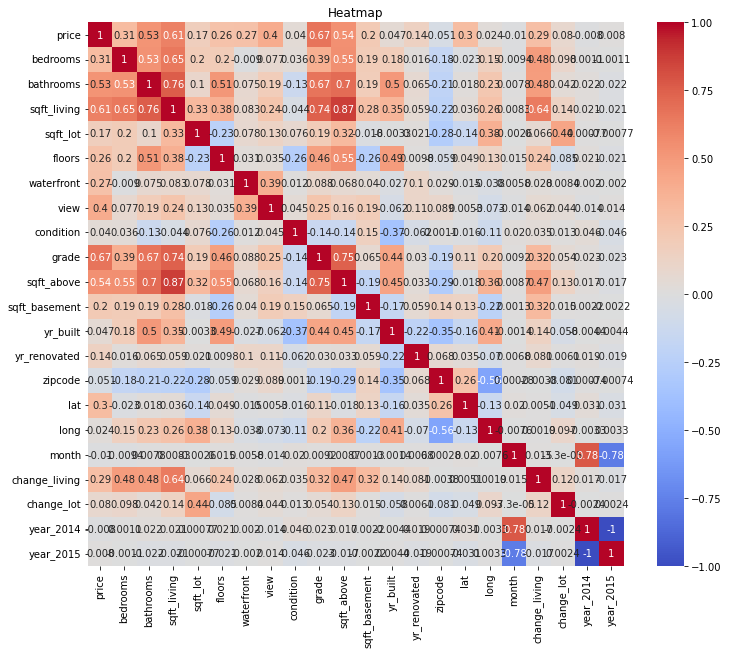

In [78]:
corr = data.corr()

# 히트맵을 통한 상관관계 확인
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap')
plt.show()

In [79]:
X = data.drop(columns=["price"])
y = data["price"]

In [80]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [81]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


random_state=2020  

# kaggle에서 데이터를 받아 코딩을 하는 과정에서 test.csv 와 submission_sample 아이디가 일치하지 않고 개수도 일치 하지 않음
# kaggle 사이트에서 test 파일 오류 
# 따라서 cloud로 다시 옮겨 진행하는 과정에서 랜덤 그리드 서치를 할 시간이 부족 로컬에서 진행한 결과를 바탕으로 모델 재정의 진행
# 참고 부탁드립니다...ㅠㅠ

"""
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=random_state),
    'XGBoost': XGBRegressor(random_state=random_state),
    'LightGBM': LGBMRegressor(random_state=random_state),
    'CatBoost': CatBoostRegressor(random_state=random_state, verbose=0),
    'RandomForest': RandomForestRegressor(random_state=random_state)
}

# 교차 검증 및 최적 모델 찾기
def evaluate_models(models, X, y, param_grids=None):
    best_rmse = float('inf')
    best_model = None
    results = []

    for name, model in models.items():
        # 교차 검증으로 성능 평가
        kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)
        cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-cv_scores)
        avg_rmse = rmse_scores.mean()
        
        print(f"{name} CV RMSE: {avg_rmse}")

        # 랜덤 서치가 필요하면 수행
        if param_grids and name in param_grids:
            random_search = RandomizedSearchCV(model, param_distributions=param_grids[name], 
                                               n_iter=10, scoring='neg_mean_squared_error', 
                                               cv=5, verbose=1, n_jobs=1, random_state=random_state)
            random_search.fit(X, y)
            best_params = random_search.best_params_
            best_model_from_search = random_search.best_estimator_
            best_score = np.sqrt(-random_search.best_score_)
            
            print(f"Best {name} Parameters: {best_params}")
            print(f"Best {name} RMSE from Randomized Search: {best_score}")

            # 최적의 모델 업데이트
            if best_score < best_rmse:
                best_rmse = best_score
                best_model = best_model_from_search
        else:
            # 교차 검증 점수로만 판단
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = model

        results.append({
            'model': name,
            'avg_rmse': avg_rmse
        })

    # 결과 DataFrame으로 정리
    results_df = pd.DataFrame(results).sort_values('avg_rmse')
    return best_model, results_df
"""

'\nmodels = {\n    \'GradientBoosting\': GradientBoostingRegressor(random_state=random_state),\n    \'XGBoost\': XGBRegressor(random_state=random_state),\n    \'LightGBM\': LGBMRegressor(random_state=random_state),\n    \'CatBoost\': CatBoostRegressor(random_state=random_state, verbose=0),\n    \'RandomForest\': RandomForestRegressor(random_state=random_state)\n}\n\n# 교차 검증 및 최적 모델 찾기\ndef evaluate_models(models, X, y, param_grids=None):\n    best_rmse = float(\'inf\')\n    best_model = None\n    results = []\n\n    for name, model in models.items():\n        # 교차 검증으로 성능 평가\n        kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)\n        cv_scores = cross_val_score(model, X, y, cv=kfold, scoring=\'neg_mean_squared_error\')\n        rmse_scores = np.sqrt(-cv_scores)\n        avg_rmse = rmse_scores.mean()\n        \n        print(f"{name} CV RMSE: {avg_rmse}")\n\n        # 랜덤 서치가 필요하면 수행\n        if param_grids and name in param_grids:\n            random_search = Ra

In [82]:
# 모델별 파라미터 그리드 정의
param_grids = {
    'CatBoost': {
        'depth': [4, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [1000, 2000, 3000],
        'l2_leaf_reg': [1, 3, 5, 7],
        'border_count': [32, 64, 128]
    },
    'XGBoost': {
        'n_estimators': [1000, 1500, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'n_estimators': [1000, 1500, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'max_depth': [-1, 10, 20]
    }
}
"""
# 모델 평가 및 최적 모델 선택
best_model, results_df = evaluate_models(models, X, y, param_grids)
"""
# Best CatBoost Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 2000, 'depth': 4, 'border_count': 128}
# Best CatBoost RMSE from Randomized Search: 79615.18082413886

model = CatBoostRegressor(learning_rate= 0.1, l2_leaf_reg= 5, iterations= 6000, depth= 4, border_count= 256, random_state=random_state, verbose=1)
# 최적 모델로 예측 및 제출 파일 생성
model.fit(X,y)

pred = model.predict(sub)  

0:	learn: 350453.3910375	total: 4.7ms	remaining: 28.2s
1:	learn: 332337.9601768	total: 8.41ms	remaining: 25.2s
2:	learn: 315609.7450540	total: 11.7ms	remaining: 23.4s
3:	learn: 300918.0936091	total: 15ms	remaining: 22.4s
4:	learn: 288073.7461162	total: 18.2ms	remaining: 21.8s
5:	learn: 275562.3610131	total: 21.5ms	remaining: 21.4s
6:	learn: 265242.8443978	total: 24.8ms	remaining: 21.2s
7:	learn: 255952.7036895	total: 27.9ms	remaining: 20.9s
8:	learn: 248191.8100293	total: 31ms	remaining: 20.6s
9:	learn: 240154.9197873	total: 34.3ms	remaining: 20.5s
10:	learn: 232944.6124888	total: 37.6ms	remaining: 20.5s
11:	learn: 226468.6529469	total: 40.8ms	remaining: 20.3s
12:	learn: 219921.7057512	total: 44ms	remaining: 20.2s
13:	learn: 214765.9862733	total: 47.1ms	remaining: 20.1s
14:	learn: 209513.5100438	total: 50.3ms	remaining: 20.1s
15:	learn: 204723.0896489	total: 53.4ms	remaining: 20s
16:	learn: 200047.0602443	total: 56.8ms	remaining: 20s
17:	learn: 196858.4174298	total: 59.7ms	remaining: 1

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [83]:
sub = pd.read_csv(sub_data_path)
submission = pd.DataFrame({
    'id': sub['id'],  # 테스트 데이터의 ID 컬럼
    'price': pred
})
submission.to_csv('submission.csv', index=False)